In [16]:
#convolutions!!!
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torch

#create first convolutional layer!
conv = nn.Conv2d(3, 16, kernel_size=3) #3 input features (RGB colors in the image), 16 outputs (feature maps) and kernel
                                        #size that will be traversing the image is 3x3.
print(conv)
print(conv.weight.shape)  #we have 16 feature maps, each made as a 3x3 kernel for each of the 3 channels that we have
print(conv.bias.shape) #we add that for every output map

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
torch.Size([16, 3, 3, 3])
torch.Size([16])


In [102]:
#checking convolution output on one image
#download the data again
mean = (0.4915, 0.4823, 0.4468)
std = (0.2470, 0.2435, 0.2616)
cifar_path = r"C:\Users\DomagalaMa\Desktop\DLWP_notes\DLWP_notes\data\CIFAR10"
new_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
label_mapping = {0:0, 2:1}
transformed_cifar10 = datasets.CIFAR10(cifar_path, 
                                       download=True, 
                                       train=True, 
                                       transform = new_transform)
cifar2 = [(image, label_mapping[label]) for (image, label) in transformed_cifar10 if (label in [0,2])]
transformed_cifar10_val = datasets.CIFAR10(cifar_path, 
                                       download=True, 
                                       train=False, 
                                       transform = new_transform)
cifar2_val = [(image, label_mapping[label]) for (image, label) in transformed_cifar10_val if (label in [0,2])]

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


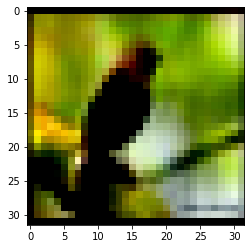

torch.Size([30, 30])


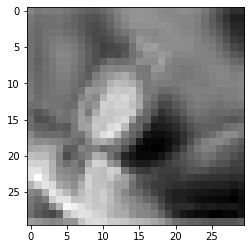

In [41]:
img, _ = cifar2[100]
plt.imshow(img.permute(1,2,0), cmap='gray')
plt.show()
#after_conv
img_conv = conv(img.unsqueeze(0))
print(img_conv[0,0].shape)
plt.imshow(img_conv[0, 0].detach().numpy(), cmap='gray')
plt.show()

In [49]:
#comparision of the shapes
print(img.unsqueeze(0).shape)
print(img_conv.shape)

#using padding to get the output to be of the same pixel resolution
conv_pad = nn.Conv2d(3,16, kernel_size=3, padding=1)
img_conv_pad = conv_pad(img.unsqueeze(0))

print(img_conv_pad.shape) #works!

torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 30, 30])
torch.Size([1, 16, 32, 32])


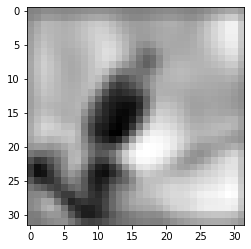

In [57]:
#manual kernel setup and detecting
with torch.no_grad():
    conv_pad.bias.zero_()
    conv_pad.weight.fill_(1.0 / 9.0)
    
img_conv_pad = conv_pad(img.unsqueeze(0))
plt.imshow(img_conv_pad[0, 0].detach().numpy(), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


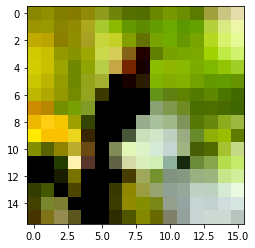

In [65]:
#downsampling techniques wiht max pooling
max_pool = nn.MaxPool2d(2) #parameter corresponds to the size of the matrix we want to downsample (here 2x2)
img_max_pool = max_pool(img)
img_max_pool.shape
plt.imshow(img_max_pool.permute(1,2,0))

In [74]:
#building model using conv and max_pool layers
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(16, 8, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      nn.Flatten(),
                      nn.Linear(8 * 8 * 8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2))

#printing the model parameter
param_list = [p.numel() for p in model.parameters()]
print(sum(param_list), param_list)

model(img.unsqueeze(0))

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


tensor([[-0.0050,  0.1667]], grad_fn=<AddmmBackward>)

In [85]:
#defining nn.Module subclass and forward pass

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x))) #first layer
        out = self.pool1(self.act1(self.conv2(x))) #second layer
        
        #after that we have our 8x8x8 output, we need to make it 1d so it fits into Linear layer
        out = out.view(-1, 8*8*8) #the -1 is the batch dimension - we don't know exactly how many samples we will have there
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        return out

In [92]:
#redefining the class to use the functionality module from pytorch
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(F.tanh(self.conv1(x)),2) #first layer
        out = F.max_pool2d(F.tanh(self.conv2(out)),2)

        out = out.view(-1, 8*8*8) #the -1 is the batch dimension - we don't know exactly how many samples we will have there

        out = self.fc2(F.tanh(self.fc1(out)))
        return out

In [93]:
#test
model = Net()  #no need to call forward function. when initializing the object it call hooks and runs forward pass automatically
model(img.unsqueeze(0))

tensor([[0.0448, 0.0778]], grad_fn=<AddmmBackward>)

In [100]:
#creating a full training loop for the new model
import datetime

def training_loop_Net(n_epochs, model, optimizer, loss, data_loader):
    
    for epoch in range(1, n_epochs + 1):
        
        epoch_loss = 0.0   #going to calculate loss for each batch
        
        for imgs, labels in data_loader:
            
            out = model(imgs)
            
            loss_f = loss(out, labels)
            
            loss_f.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss_f
            
#         if epoch == 1 or epoch % 10 == 0:
        print(f"{datetime.datetime.now()}, epoch {epoch}, loss {epoch_loss/len(data_loader)}")
            
    return    

In [101]:
n_epochs = 100
learning_rate = 1e-2
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss = nn.CrossEntropyLoss()
data_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle = True)

training_loop_Net(n_epochs, model, optimizer, loss, data_loader)

2020-08-09 14:23:31.401637, epoch 1, loss 0.5839462876319885
2020-08-09 14:23:37.030634, epoch 2, loss 0.4894430637359619
2020-08-09 14:23:42.991746, epoch 3, loss 0.45859625935554504
2020-08-09 14:23:49.448535, epoch 4, loss 0.428885817527771
2020-08-09 14:23:55.806588, epoch 5, loss 0.4007994532585144
2020-08-09 14:24:03.697556, epoch 6, loss 0.377450555562973
2020-08-09 14:24:10.903349, epoch 7, loss 0.3594116270542145
2020-08-09 14:24:18.033345, epoch 8, loss 0.34684211015701294
2020-08-09 14:24:25.335881, epoch 9, loss 0.3369998335838318
2020-08-09 14:24:32.505770, epoch 10, loss 0.3302081227302551
2020-08-09 14:24:39.754445, epoch 11, loss 0.32231977581977844
2020-08-09 14:24:46.877456, epoch 12, loss 0.31748780608177185
2020-08-09 14:24:54.214895, epoch 13, loss 0.3133796751499176
2020-08-09 14:25:01.410227, epoch 14, loss 0.3108367919921875
2020-08-09 14:25:08.787559, epoch 15, loss 0.30696219205856323
2020-08-09 14:25:15.892617, epoch 16, loss 0.30093955993652344
2020-08-09 14

In [110]:
print(model(img.unsqueeze(0)))
_, predicted= torch.max(model(img.unsqueeze(0)), 1)
print(predicted)

tensor([[-4.6492,  4.8141]], grad_fn=<AddmmBackward>)
tensor([1])


In [115]:
#validation of results
def validate(model, train_set, val_set):
    for name, loader in [("train", train_set), ("val", val_set)]:
        correct, total = 0,0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, labels_pred = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((labels_pred == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name , correct / total))

        
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle = False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle = False)
validate(model, train_loader, val_loader)

c:\users\domagalama\appdata\local\programs\python\python36\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy train: 0.94
Accuracy val: 0.88


2000

In [129]:
#saving a good model
import os
data_path = r"C:\Users\DomagalaMa\Desktop\DLWP_notes\DLWP_notes\models"
torch.save(model.state_dict(), os.path.join(data_path, "birds_vs_airplanes.pt"))

In [130]:
#loading it for test
model = Net()
model.load_state_dict(torch.load(os.path.join(data_path, "birds_vs_airplanes.pt")))

<All keys matched successfully>

In [123]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on {device}")

Training on cpu


In [124]:
#one more loop but with tensors moving to CUDA if available
def training_loop_Net(n_epochs, model, optimizer, loss, data_loader):
    
    for epoch in range(1, n_epochs + 1):
        
        epoch_loss = 0.0   #going to calculate loss for each batch
        
        for imgs, labels in data_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            out = model(imgs)
            
            loss_f = loss(out, labels)
            
            loss_f.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss_f
            
#         if epoch == 1 or epoch % 10 == 0:
        print(f"{datetime.datetime.now()}, epoch {epoch}, loss {epoch_loss/len(data_loader)}")
            
    return    

In [125]:
n_epochs = 20
learning_rate = 1e-2
model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss = nn.CrossEntropyLoss()
data_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle = True)

training_loop_Net(n_epochs, model, optimizer, loss, data_loader)

c:\users\domagalama\appdata\local\programs\python\python36\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


2020-08-09 18:08:44.709138, epoch 1, loss 0.59394770860672
2020-08-09 18:08:50.522615, epoch 2, loss 0.48827987909317017
2020-08-09 18:08:56.729045, epoch 3, loss 0.4526020586490631
2020-08-09 18:09:02.849707, epoch 4, loss 0.4202515780925751
2020-08-09 18:09:09.133927, epoch 5, loss 0.3892238438129425
2020-08-09 18:09:17.310731, epoch 6, loss 0.36603474617004395
2020-08-09 18:09:26.145149, epoch 7, loss 0.3518466353416443
2020-08-09 18:09:34.437009, epoch 8, loss 0.34080058336257935
2020-08-09 18:09:42.810628, epoch 9, loss 0.33182090520858765
2020-08-09 18:09:51.270338, epoch 10, loss 0.32443007826805115
2020-08-09 18:09:59.378046, epoch 11, loss 0.31919237971305847
2020-08-09 18:10:07.790243, epoch 12, loss 0.3172496259212494
2020-08-09 18:10:16.605356, epoch 13, loss 0.31262636184692383
2020-08-09 18:10:25.763510, epoch 14, loss 0.3075704276561737
2020-08-09 18:10:33.358611, epoch 15, loss 0.30704084038734436
2020-08-09 18:10:40.589468, epoch 16, loss 0.30327141284942627
2020-08-09

In [131]:
#loading a model from a different device
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(os.path.join(data_path, "birds_vs_airplanes.pt"), map_location=device))

<All keys matched successfully>

In [132]:
#ResNet construction based on our earlier models
import torch.functional as F
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1//2, 32)
        self.fc1 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out #remembering the output of the second layer and adding it to the pooling further
        out = F.max_pool2d(torch.relu(self.conv3(x)) + out, 2)
        out = out.view(-1, 4 * 4 * n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out